In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import specutils 
import ccdproc
from astropy.convolution import convolve, Box1DKernel
datapath = '/Users/jgreco/local-io/LBT-2018B/data/'

In [84]:
from matplotlib.widgets import Cursor


In [81]:
import scipy.signal

In [2]:
fn = datapath + 'mods1r.20180917.0004_otf.fits'
ccd = ccdproc.CCDData.read(fn)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


In [3]:
nccd = ccdproc.cosmicray_lacosmic(ccd)

In [82]:
def ap_trace(img, fmask=(1,), nsteps=20, interac=False,
             recenter=False, prevtrace=(0,), bigbox=15,
             Saxis=1, display=False):
    """
    Trace the spectrum aperture in an image
    Assumes wavelength axis is along the X, spatial axis along the Y.
    Chops image up in bins along the wavelength direction, fits a Gaussian
    within each bin to determine the spatial center of the trace. Finally,
    draws a cubic spline through the bins to up-sample the trace.
    Parameters
    ---------
    img : 2d numpy array
        This is the image, stored as a normal numpy array. Can be read in
        using astropy.io.fits like so:
        >>> hdu = fits.open('file.fits')  # doctest: +SKIP
        >>> img = hdu[0].data  # doctest: +SKIP
    nsteps : int, optional
        Keyword, number of bins in X direction to chop image into. Use
        fewer bins if ap_trace is having difficulty, such as with faint
        targets (default is 50, minimum is 4)
    fmask : array-like, optional
        A list of illuminated rows in the spatial direction (Y), as
        returned by flatcombine.
    interac : bool, optional
        Set to True to have user click on the y-coord peak. (Default is
        False)
    recenter : bool, optional
        Set to True to use previous trace, but allow small shift in
        position. Currently only allows linear shift (Default is False)
    bigbox : float, optional
        The number of sigma away from the main aperture to allow to trace
    display : bool, optional
        If set to true display the trace over-plotted on the image
    Saxis : int, optional
        Set which axis the spatial dimension is along. 1 = Y axis, 0 = X.
        (Default is 1)
    Returns
    -------
    my : array
        The spatial (Y) positions of the trace, interpolated over the
        entire wavelength (X) axis
    """

    # define the wavelength axis
    Waxis = 0
    # add a switch in case the spatial/wavelength axis is swapped
    if Saxis is 0:
        Waxis = 1

    print('Tracing Aperture using nsteps='+str(nsteps))
    # the valid y-range of the chip
    if (len(fmask)>1):
        ydata = np.arange(img.shape[Waxis])[fmask]
    else:
        ydata = np.arange(img.shape[Waxis])

    # need at least 4 samples along the trace. sometimes can get away with very few
    if (nsteps<4):
        nsteps = 4

    # median smooth to crudely remove cosmic rays
    img_sm = img.copy() #scipy.signal.medfilt2d(img, kernel_size=(5,5))

    #--- Pick the strongest source, good if only 1 obj on slit
    ztot = img_sm.sum(axis=Saxis)[ydata]
    yi = np.arange(img.shape[Waxis])[ydata]
    peak_y = yi[np.nanargmax(ztot)]
    peak_guess = [np.nanmax(ztot), np.nanmedian(ztot), peak_y, 2.]

    #-- allow interactive mode, if mult obj on slit
    if interac is True and recenter is False:
        class InteracTrace(object):
            def __init__(self):
                self.fig = plt.figure()
                self.ax = self.fig.add_subplot(111)
                self.ax.plot(yi, ztot)
                plt.ylabel('Counts (Image summed in X direction)')
                plt.xlabel('Y Pixel')
                plt.title('Click on object!')

                self.cursor = Cursor(self.ax, useblit=False, horizOn=False,
                                     color='red', linewidth=1 )
                self.connect = self.fig.canvas.mpl_connect
                self.disconnect = self.fig.canvas.mpl_disconnect
                self.ClickID = self.connect('button_press_event', self.__onclick__)

                return

            def __onclick__(self,click):
                if self.fig.canvas.manager.toolbar._active is None:
                    self.xpoint = click.xdata
                    self.ypoint = click.ydata
                    self.disconnect(self.ClickID) # disconnect from event
                    self.cursor.disconnect_events()
                    self.cursor._update()
                    plt.close() # close window when clicked
                    return self.xpoint, self.ypoint
                else:
                    pass

        theclick = InteracTrace()
        plt.show()

        xcl = theclick.xpoint
        # ycl = theclick.ypoint

        peak_guess[2] = xcl

    #-- use middle of previous trace as starting guess
    if (recenter is True) and (len(prevtrace)>10):
        peak_guess[2] = np.nanmedian(prevtrace)

    #-- fit a Gaussian to peak
    popt_tot, pcov = curve_fit(_gaus, yi[np.isfinite(ztot)], ztot[np.isfinite(ztot)], p0=peak_guess)
    #-- only allow data within a box around this peak
    ydata2 = ydata[np.where((ydata>=popt_tot[2] - popt_tot[3]*bigbox) &
                            (ydata<=popt_tot[2] + popt_tot[3]*bigbox))]

    yi = np.arange(img.shape[Waxis])[ydata2]
    # define the X-bin edges
    xbins = np.linspace(0, img.shape[Saxis], nsteps)
    ybins = np.zeros_like(xbins)

    for i in range(0,len(xbins)-1):
        #-- fit gaussian w/i each window
        if Saxis is 1:
            zi = img_sm[ydata2, xbins[i]:xbins[i+1]].sum(axis=Saxis)
        else:
            zi = img_sm[xbins[i]:xbins[i+1], ydata2].sum(axis=Saxis)

        pguess = [np.nanmax(zi), np.nanmedian(zi), yi[np.nanargmax(zi)], 2.]
        popt,pcov = curve_fit(_gaus, yi[np.isfinite(ztot)], zi[np.isfinite(ztot)], p0=pguess)

        # if gaussian fits off chip, then use chip-integrated answer
        if (popt[2] <= min(ydata)+25) or (popt[2] >= max(ydata)-25):
            ybins[i] = popt_tot[2]
            popt = popt_tot
        else:
            ybins[i] = popt[2]

        # update the box it can search over, in case a big bend in the order
        # ydata2 = ydata[np.where((ydata>= popt[2] - popt[3]*bigbox) &
        #                         (ydata<= popt[2] + popt[3]*bigbox))]

    # recenter the bin positions, trim the unused bin off in Y
    mxbins = (xbins[:-1]+xbins[1:]) / 2.
    mybins = ybins[:-1]

    # run a cubic spline thru the bins
    ap_spl = UnivariateSpline(mxbins, mybins, ext=0, k=3, s=0)

    # interpolate the spline to 1 position per column
    mx = np.arange(0, img.shape[Saxis])
    my = ap_spl(mx)

    if display is True:
        plt.figure()
        plt.imshow(np.log10(img),origin='lower',aspect='auto',cmap=cm.Greys_r)
        plt.autoscale(False)
        plt.plot(mx,my,'b',lw=1)
        # plt.plot(mx,my+popt_tot[3]*bigbox,'y')
        # plt.plot(mx,my-popt_tot[3]*bigbox,'y')
        plt.show()

    print("> Trace gaussian width = "+str(popt_tot[3])+' pixels')
    return my


Tracing Aperture using nsteps=20


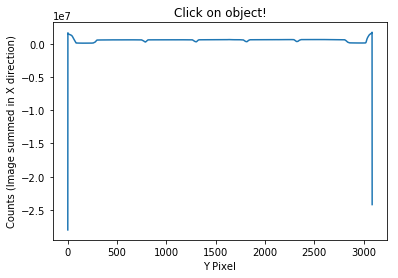

AttributeError: 'InteracTrace' object has no attribute 'xpoint'

In [85]:
ap_trace(nccd.data[:, col_slice], interac=True)

In [31]:
def ap_extract(img, trace, apwidth=8, skysep=3, skywidth=7, skydeg=0,
               coaddN=1):
    """
    1. Extract the spectrum using the trace. Simply add up all the flux
    around the aperture within a specified +/- width.
    Note: implicitly assumes wavelength axis is perfectly vertical within
    the trace. An major simplification at present. To be changed!
    2. Fits a polynomial to the sky at each column
    Note: implicitly assumes wavelength axis is perfectly vertical within
    the trace. An important simplification.
    3. Computes the uncertainty in each pixel
    Parameters
    ----------
    img : 2d numpy array
        This is the image, stored as a normal numpy array. Can be read in
        using astropy.io.fits like so:
        >>> hdu = fits.open('file.fits') # doctest: +SKIP
        >>> img = hdu[0].data # doctest: +SKIP
    trace : 1-d array
        The spatial positions (Y axis) corresponding to the center of the
        trace for every wavelength (X axis), as returned from ap_trace
    apwidth : int, optional
        The width along the Y axis on either side of the trace to extract.
        Note: a fixed width is used along the whole trace.
        (default is 8 pixels)
    skysep : int, optional
        The separation in pixels from the aperture to the sky window.
        (Default is 3)
    skywidth : int, optional
        The width in pixels of the sky windows on either side of the
        aperture. (Default is 7)
    skydeg : int, optional
        The polynomial order to fit between the sky windows.
        (Default is 0)
    Returns
    -------
    onedspec : 1-d array
        The summed flux at each column about the trace. Note: is not
        sky subtracted!
    skysubflux : 1-d array
        The integrated sky values along each column, suitable for
        subtracting from the output of ap_extract
    fluxerr : 1-d array
        the uncertainties of the flux values
    """

    onedspec = np.zeros_like(trace)
    skysubflux = np.zeros_like(trace)
    fluxerr = np.zeros_like(trace)

    for i in range(0,len(trace)):
        #-- first do the aperture flux
        # juuuust in case the trace gets too close to the edge
        widthup = apwidth
        widthdn = apwidth
        if (trace[i]+widthup > img.shape[0]):
            widthup = img.shape[0]-trace[i] - 1
        if (trace[i]-widthdn < 0):
            widthdn = trace[i] - 1

        # simply add up the total flux around the trace +/- width
        onedspec[i] = img[trace[i]-widthdn:trace[i]+widthup+1, i].sum()

        #-- now do the sky fit
        itrace = int(trace[i])
        y = np.append(np.arange(itrace-apwidth-skysep-skywidth, itrace-apwidth-skysep),
                      np.arange(itrace+apwidth+skysep+1, itrace+apwidth+skysep+skywidth+1))

        z = img[y,i]
        if (skydeg>0):
            # fit a polynomial to the sky in this column
            pfit = np.polyfit(y,z,skydeg)
            # define the aperture in this column
            ap = np.arange(trace[i]-apwidth, trace[i]+apwidth+1)
            # evaluate the polynomial across the aperture, and sum
            skysubflux[i] = np.sum(np.polyval(pfit, ap))
        elif (skydeg==0):
            skysubflux[i] = np.nanmean(z)*(apwidth*2.0 + 1)

        #-- finally, compute the error in this pixel
        sigB = np.std(z) # stddev in the background data
        N_B = len(y) # number of bkgd pixels
        N_A = apwidth*2. + 1 # number of aperture pixels

        # based on aperture phot err description by F. Masci, Caltech:
        # http://wise2.ipac.caltech.edu/staff/fmasci/ApPhotUncert.pdf
        fluxerr[i] = np.sqrt(np.sum((onedspec[i]-skysubflux[i])/coaddN) +
                             (N_A + N_A**2. / N_B) * (sigB**2.))

    return onedspec, skysubflux, fluxerr

In [5]:
colmin, colmax = 1530, 7426
rowmin, rowmax = 300, 2815
slicer = np.s_[rowmin:rowmax, colmin:colmax]

col_slice = np.s_[colmin:colmax]

In [6]:
def extract(data, row, width):
    return data[row-width//2: row+width//2 + 1, :]

In [34]:

stack_func = np.mean

sky_row_bot = 1460
sky_row_top = 2053

src_row = 1627

source = stack_func(extract(nccd.data[:, col_slice], src_row, 25), axis=0)

sky_top =  np.median(extract(nccd.data[:, col_slice], sky_row_top, 100), axis=0)
sky_bot =  np.median(extract(nccd.data[:, col_slice], sky_row_bot, 100), axis=0)

sky = 0.5 * (sky_bot + sky_top)

In [33]:
ncols = nccd.data[:, col_slice].shape[1]

In [75]:
onedspec, skysubflux, fluxerr = ap_extract(
    nccd.data[:, col_slice], np.ones(ncols, dtype=int)*src_row, skydeg=3, apwidth=40, skysep=5, skywidth=15,
)

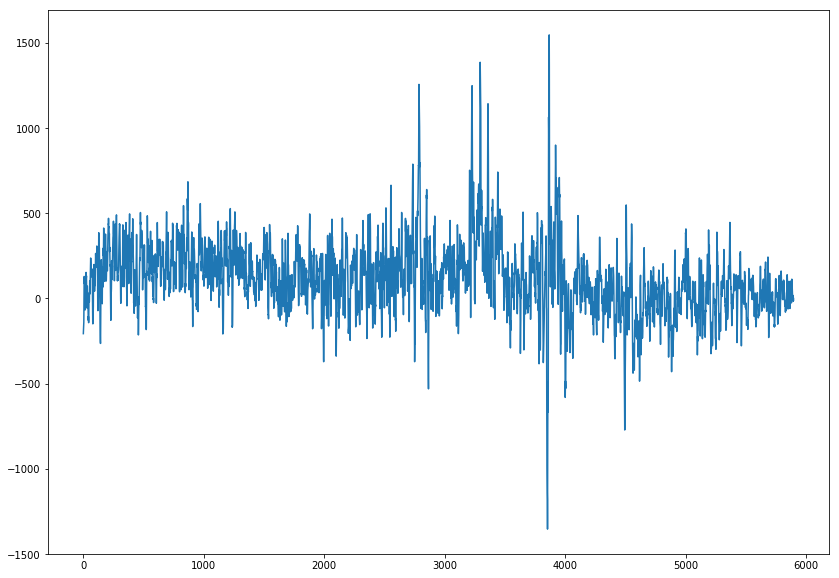

In [76]:
plt.figure(figsize=(14, 10))

spec_smooth = convolve(onedspec-skysubflux, Box1DKernel(8))
sky_smooth = convolve(skysubflux, Box1DKernel(8))
plt.plot(spec_smooth)
#plt.plot(sky_smooth);

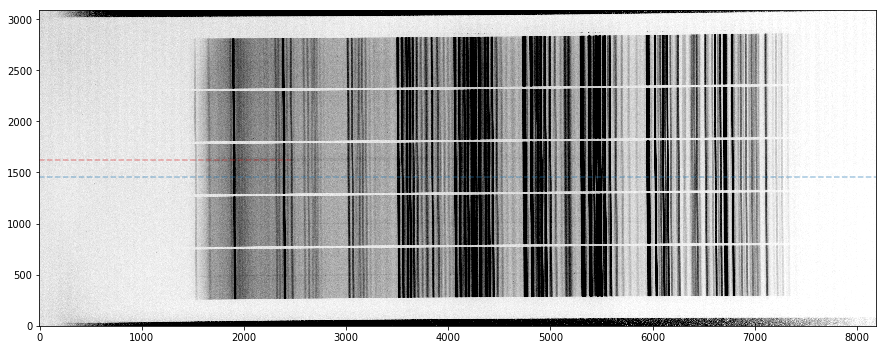

In [74]:
plt.figure(figsize=(15, 15))
vmin, vmax = np.percentile(nccd.data, [5, 90])
plt.imshow(nccd.data, cmap='gray_r', vmin=vmin, vmax=vmax, origin='lower');
plt.axhline(y=1627, xmax=0.3, ls='--', c='tab:red', alpha=0.4)
plt.axhline(y=1460, ls='--', c='tab:blue', alpha=0.4);